In [1]:
%matplotlib inline

import markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text

## Introduction

For my project, I will be evaluating the Lending Club loan dataset. In specific, I will be evaluating loans from the 2017 Quarter 1 period. This dataset includes information of all loans given by LendingClub.com. The goal of this project is to be able to predict the probability of default of a loan given a certain set of features. Some of the most important features (in my opinion), are:

- *annual_inc*: The self-reported annual income provided by the borrower during registration.
- *chargeoff_within_12_mths*: Number of charge-offs within 12 months
- *emp_length*: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
- *grade*: Lending Club assigned loan grade
- *sub_grade*: Lending Club assigned loan subgrade
- *home_ownership*: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
- *int_rate*: Interest Rate on the loan
- *loan_amt*: The listed amount of the loan applied for by the borrower.
- *pub_rec_bankruptcies*: Number of public record bankruptcies
- *totalAcc*: The total number of credit lines currently in the borrower's credit file

While there are many more variables, 145 to be exact, I believe these are some of the most important features that will help predict whether or not a loan will default.

Moving onto our target variable, we will be trying to predict:

- *loan_status*: Current status of the loan

## Data Loading and Exploration

Now that we have introduced the data and our goal for it, we will want to load the data. But first, let's start with importing all needed libraries to run this project.

In [22]:
lending_data = pd.read_csv("loan.csv", na_values = "", low_memory = False)

We can now take a full look at all of the variables included in this data and the total number of observations and variables in this dataset.

In [23]:
total_obs1 = lending_data.shape[0]
total_vars1 = lending_data.shape[1]

lending_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


Total observations in this dataset: {{ total_obs1 }}

Total variables in this dataset: {{total_vars1}}

**Target Variable Exploration**

So, as stated above, there are a lot of variables given to help predict whether or not a person will default on their loan. Let's explore our target variable, *loan_status*, more closely to get an idea of what possible values this variable can take.

In [4]:
unique_loanstatus_vals = lending_data.loan_status.unique()
for loanstatus in unique_loanstatus_vals:
    print("{0}".format(loanstatus))

Current
Fully Paid
Late (31-120 days)
In Grace Period
Charged Off
Late (16-30 days)
Default
Does not meet the credit policy. Status:Fully Paid
Does not meet the credit policy. Status:Charged Off


There are a total of 9 different values that *loan_status* can take. Since we are interested in predicting whether someone will default on their loan or not, we will clean this variable later on so it only takes on values default or not default. Forn now, let's take a look at how many of each value we have using a bar graph.

In [5]:
class TextHandler(HandlerBase):
    def create_artists(self, legend, tup, xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width, height/2, tup[0], fontsize = fontsize,
                   ha = "right", va = "center", color = tup[1], fontweight = "bold")
        return [tx]

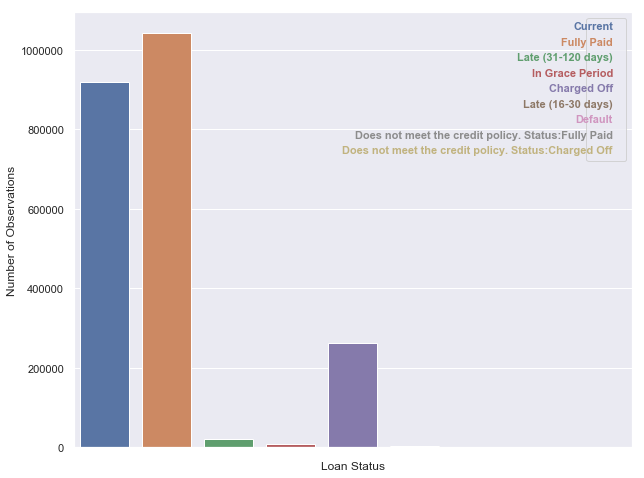

<Figure size 1152x432 with 0 Axes>

In [6]:
plt.figure(figsize = (10, 8))
sb.set(style = "darkgrid")
plot = sb.countplot(x = "loan_status", data = lending_data)

handltext = list(unique_loanstatus_vals)
labels = ["" for i in range(9)]

t = plot.get_xticklabels()
labeldic = dict(zip(handltext, labels))
labels = [labeldic[h.get_text()] for h in t]
handles = [(h.get_text(), c.get_fc()) for h, c in zip(t, plot.patches)]

plot.legend(handles, labels, handler_map = {tuple: TextHandler()})

plot.set(xticklabels = [])
plt.xlabel("Loan Status")
plt.ylabel("Number of Observations")
plt.figure(figsize = (16, 6))
plt.show(plot)

Looking at the bar graph above, we can see that the top three values that *loan_status* takes is "Charged Off", "Current", and "Fully Paid". All other values are very low in the number of observations.

Since we are interested in predicting whether or not someone will default on a loan, we can remove the values that will be not helpful in making this prediction. I will justify why I am removing each value from *loan_status* that I believe is not helpful.

- "Current": If you are current on your loan, this does not mean you will remain current. You can eventually default on the loan or pay it off, we do not know.
- "In Grace Period": If you are in the grace period, you can always go back to being current on your loan or eventually default. We do not know.
- "Late (16-30 days)": If you are late on paying your loan, you can always catch up on payments or eventually default. We do not know.
- "Late (31-120 days)": If you are late on paying your loan, you can always catch up on payments or eventually default. We do not know.

So, I will be keeping these values to eventually create a single variable that has the values "Default" or "Not Default"

- "Charged Off": This loan was defaulted on and sent to collections, and Lending Club has charged off the loan and considered it a loss.
- "Default": This loan was defaulted on.
- "Does not meet the credit policy. Status: Charged Off": This loan was defaulted on and sent to collections, and Lending Club has charged off the loan and considered it a loss.
- "Does not meet the credit policy. Status: Fully Paid": This loan was fully paid off and was not defaulted on.
- "Fully Paid": This loan was fully pauid off and was not defaulted on.

Let's clean the data a little bit now by removing all rows that have any of the four values for *loan_status* in order to remove these values.

In [7]:
lending_data_target_clean = lending_data[lending_data.loan_status.isin(["Charged Off",
                                                                      "Default",
                                                                     "Does not meet the credit policy. Status:Charged Off",
                                                                     "Does not meet the credit policy. Status:Fully Paid",
                                                                     "Fully Paid"])]

In [8]:
unique_loanstatus_vals2 = lending_data_target_clean.loan_status.unique()
total_obs2 = lending_data_target_clean.shape[0]

With those values of *loan_status* removed, we have shrunken the data to only {{total_obs2}} rows, which is much smaller and more manageable. Let's take a look at a bar plot of *loan_status* once again.

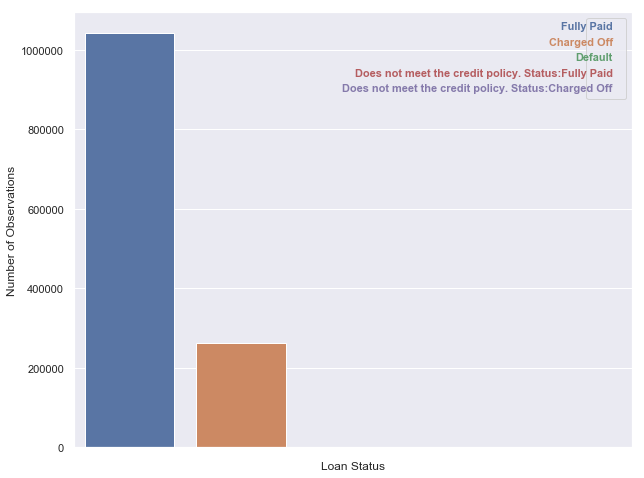

In [9]:
plt.figure(figsize = (10, 8))
sb.set(style = "darkgrid")
plot = sb.countplot(x = "loan_status", data = lending_data_target_clean)

handltext = list(unique_loanstatus_vals)
labels = ["" for i in range(9)]

t = plot.get_xticklabels()
labeldic = dict(zip(handltext, labels))
labels = [labeldic[h.get_text()] for h in t]
handles = [(h.get_text(), c.get_fc()) for h, c in zip(t, plot.patches)]

plot.legend(handles, labels, handler_map = {tuple: TextHandler()})

plot.set(xticklabels = [])
plt.xlabel("Loan Status")
plt.ylabel("Number of Observations")
plt.show(plot)

This plot looks much cleaner with the redudant levels of *loan_status* removed. Let's now create our final variable of *loan_status*, that we will use for model building. This variable will include levels of "Default" or "Not Default".

In [10]:
defaults= ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off"]

lending_data_target_clean["loan_status_final"] = np.where(
    lending_data_target_clean.loan_status.isin(defaults), "Default", "Not Default")

C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Let's take a look at the bar graph one more time for our created variable *loan_status_final*.

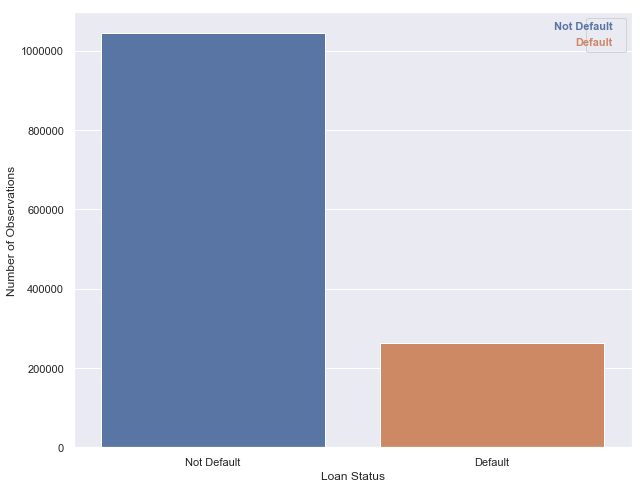

In [11]:
plt.figure(figsize = (10, 8))
sb.set(style = "darkgrid")
plot = sb.countplot(x = "loan_status_final", data = lending_data_target_clean)

handltext = lending_data_target_clean["loan_status_final"].unique()
labels = ["" for i in range(2)]

t = plot.get_xticklabels()
labeldic = dict(zip(handltext, labels))
labels = [labeldic[h.get_text()] for h in t]
handles = [(h.get_text(), c.get_fc()) for h, c in zip(t, plot.patches)]

plot.legend(handles, labels, handler_map = {tuple: TextHandler()})

plt.xlabel("Loan Status")
plt.ylabel("Number of Observations")
plt.show(plot)

With the data cleaned and redudant rows removed, let's move on to exploring some of the important "X" variables, or features in this dataset. I will be taking a look at the three most important features, which I have picked.

- *annual_inc*: The self-reported annual income provided by the borrower during registration.
- *int_rate*: Interest Rate on the loan
- *loan_amt*: The listed amount of the loan applied for by the borrower.

I have picked *annual_inc* as I believe this will play a crucial factor on whether someone will default on their loan or not. My belief is that the higher the income someone has, the less chance they have of defaulting on the loan. Let's explore some summary statistics on this variable and also the distribution of it through the use of a histogram.

In [12]:
lending_data_target_clean["annual_inc"].describe().apply(lambda s: format(s, '.2f'))

count     1306383.00
mean        76148.79
std         70045.82
min             0.00
25%         45760.00
50%         65000.00
75%         90000.00
max      10999200.00
Name: annual_inc, dtype: object

Looking at the summary statistics of *annual_inc*, we have some interesting results to make note of. First of all, we need to pay attention to the number of "NA's" in this variable, which is 4. For these NA's, we can either remove the rows or impute a value into them. We will make this decision later on. Our minimum *annual_inc* is zero, which seems off as I would not believe that a loan would be given to someone with zero income. Our maximum *annual_inc* is 10,999,200, which also seems off as that is a lot of income and I am doubtful someone would need a loan with that much income. The average *annual_inc* is 76,149, which is a reasonable average for annual incomes on people requesting loans. It should be noted that *annual_inc* is a field that the loanee provides to Lending Club, so it is safe to believe that some people did not enter in their true annual income.

Let's now take a look at the summary of *annual_inc*, when grouped by whether or not they have defaulted on their loan. We will be ignoring the NA values for this summary.

In [13]:
lending_data_target_clean.groupby("loan_status_final").annual_inc.describe()[["mean", "std", "min", "max"]]

,mean,std,min,max
loan_status_final,,,,
Default,70324.951694,65258.443710,0.0,9500000.0
Not Default,77612.915613,71123.809717,0.0,10999200.0


Looking at the summary when grouped by whether or not the person has defaulted on their loan, we can see that the minimum income and maximum income really do not differ by much as each group has a minimum of zero and a maximum of a ridiculously high number. The mean incomes however differ by a good amount, about 7,000. This difference in means falls in limne with my belief that the higher someones income is the less chance they have of defaulting on their loan.

With summary statistics aside, let's take a look at the histogram of *annual_inc* to get an idea of the distribution. 

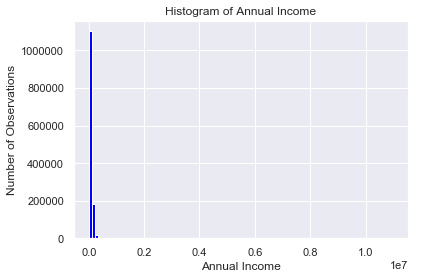

In [21]:
annual_inc_gt500k = lending_data_target_clean[lending_data_target_clean["annual_inc"] > 500000].shape[0]
annual_inc_gt500kperc = 100*(annual_inc_gt500k / lending_data_target_clean.shape[0])

plt.hist(lending_data_target_clean["annual_inc"], bins = 100, color = "blue")
plt.xlabel("Annual Income")
plt.ylabel("Number of Observations")
plt.title("Histogram of Annual Income")
plt.show()

Looking at the histogram above, we don't really get a good idea of the distribution of *annual_inc* when allowing the range of the x-axis to span all of the way to the maximum value of 10,999,200. I am going to also include a histogram of *annual_inc* with an xrange of (0, 500,000) to get a better idea of the distribution. I have chosen 500,000 as that seems to be around the flatline of this histogram, also diving deeper into the data there are only {{annual_inc_gt500k}} observations greater than 500,000 which is only {{annual_inc_gt500kperc}}% of the data which is very minimal.

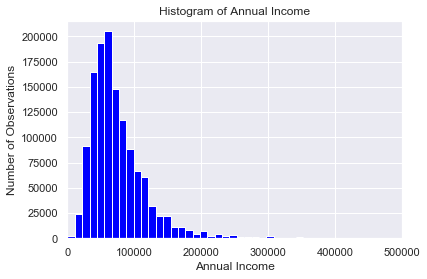

In [114]:
plt.hist(lending_data_target_clean["annual_inc"], bins = 1000, color = "blue")
plt.xlim(0, 500000)
plt.xlabel("Annual Income")
plt.ylabel("Number of Observations")
plt.title("Histogram of Annual Income")
plt.show()

Looking at the histogram of *annual_inc* with a limit of 500,000, we can see that most incomes surround the mean as the histogram has a very high peak. This distribution looks normal-ish if you remove outliers, however does have a fatter right tail as incomes can continue to increase while they cannot go below zero (I hope).

Moving on from *annual_inc*, let's now take a *int_rate*. I believe that this variable plays a crucial role in predicting the target variable of whether or not someone will default on their loan as interest rates are tied directly to how risky the loanee is. The more risky it is to borrow someone money (less chance that they will pay back the loan), the higher the interest rate you would charge them. Therefore, the higher the interest rate the higher the chance of someone defaulting on a loan. Let's explore some summary statistics on this variable and also the distribution of it through the use of a histogram.

In [121]:
lending_data_target_clean["int_rate"].describe().apply(lambda x: format(x, '.2f'))

count    1306387.00
mean          13.26
std            4.76
min            5.31
25%            9.75
50%           12.74
75%           15.99
max           30.99
Name: int_rate, dtype: object

Looking at the summary statistics of *int_rate*, we have some interesting results to make note of. For the case of this variable, we have no NA values which is fantastic. Our minimum *int_rate* is 5.31%, which is a good interest rate for a loan. Our maximum *int_rate* is 30.99%, which is a very high interest rate on a loan and therefore this person was most likely very risk to give a loan to. The average *int_rate* is 13.26%, which is a reasonable average interest rate for loans given to all types of people.

Let's now take a look at the summary of *int_rate*, when grouped by whether or not they have defaulted on their loan.

In [124]:
lending_data_target_clean.groupby("loan_status_final")["int_rate"].describe()[["mean", "std", "min", "max"]]

,mean,std,min,max
loan_status_final,,,,
Default,15.708974,4.893239,5.31,30.99
Not Default,12.643303,4.518351,5.31,30.99


Looking at the statistics of *int_rate* when grouped by whether or not someone has defaulted on their loan, once again we see that the minimum and maximum values are similar (equal in this case). I believe they are equal due to this being the minimum and maximum interest rates offered by Lending Club. However, when looking at the mean *int_rate* between groups, we can see that those who did not default on their loan have a lower mean interest rate. This falls in line with my belief that those with lower interest rates are less risky and therefore have less chance to default on their loan.

With summary statistics aside, let's take a look at the histogram of *int_rate* to get an idea of the distribution.

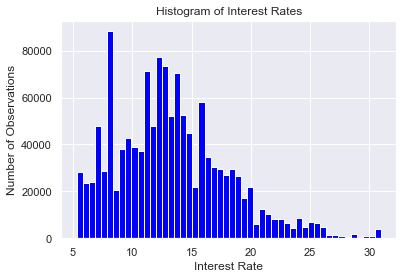

In [128]:
plt.hist(lending_data_target_clean["int_rate"], bins = 50, color = "blue")
plt.xlabel("Interest Rate")
plt.ylabel("Number of Observations")
plt.title("Histogram of Interest Rates")
plt.show()

Looking at the histogram of *int_rate*, it appears to have a normal-ish distribution with most interest rates being near the mean. However, it is right-skewed as more risky people receive higher interest rates therefore causing the distribution to have a fatter right tail.

Lastly, let's take a look at *loan_amt*. I believe that this variable also plays a crucial role in predicting whether or not someone will default on their loan as the larger the loan amount someone takes out I believe there is less chance that they plan on (and are capable of), repaying the loan. However, it should be noted that this is my belief and there could be cases where someone with more income needs a larger loan and is therefore capable of paying it back. Let's explore some summary statistics on this variable and also the distribution of it through the use of a histogram.

In [130]:
lending_data_target_clean["loan_amnt"].describe().apply(lambda x: format(x, 'f'))

count    1306387.000000
mean       14405.523421
std         8698.613361
min          500.000000
25%         8000.000000
50%        12000.000000
75%        20000.000000
max        40000.000000
Name: loan_amnt, dtype: object

Looking at the summary statistics of *loan_amnt*, we have some interesting results to make note of. For the case of this variable, we have no NA values which is fantastic. Our minimum *loan_amnt* is 500, which is a rather small loan and is likely to be paid back. Our maximum *loan_amnt* is 40,000, which is a larger-than-average loan and therefore carries more risk of being defaulted on. The average *loan_amnt* is 14,406, which seems high for an average of the given loan amounts.

Let's now take a look at the summary of *loan_amnt*, when grouped by whether or not they have defaulted on their loan.

In [132]:
lending_data_target_clean.groupby("loan_status_final")["loan_amnt"].describe()[["mean", "std", "min", "max"]]

,mean,std,min,max
loan_status_final,,,,
Default,15531.548179,8797.625728,500.0,40000.0
Not Default,14122.440274,8650.522582,500.0,40000.0


Looking at the statistics of *loan_amnt* when grouped by whether or not someone has defaulted on their loan, once again we see that the minimum and maximum values are similar (equal in this case). I believe they are equal due to this being the minimum and maximum loan amounts offered by Lending Club. However, when looking at the mean *loan_amnt* between groups, we can see that those who did not default on their loan have a lower mean loan amount. This falls in line with my belief that those with a lower loan amount have less chance of defaulting on their loan.

With summary statistics aside, let's take a look at the histogram of *loan_amnt* to get an idea of the distribution.

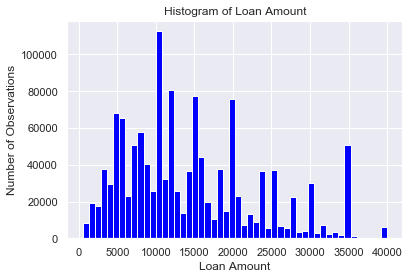

In [133]:
plt.hist(lending_data_target_clean["loan_amnt"], bins = 50, color = "blue")
plt.xlabel("Loan Amount")
plt.ylabel("Number of Observations")
plt.title("Histogram of Loan Amount")
plt.show()

Looking at the histogram of *loan_amnt*, I cannot see any real distribution underlying the data. I believe that this could be due to people needing different loan amounts for different needs, therefore leaving no real pattern and distribution to follow.

With the exploration of our target variable as well as three of my believed important variables, we are now going to take a look at the box-plot between each of these three variables, *annual_inc*, *int_rate*, and *loan_amnt*, and the output variable, *loan_status*. The box-plot will provide us a graph that will differentiate between each level of *loan_status* to take a look at the difference in mean and variance and overall density of each level.

**Comparing X's vs Y**

Let's first take a look at the box-plot between *annual_inc* and *loan_status*. Note that I will be once again limiting the annual income to a maximum of 500,000 to disregard outliers and obvious incorrect incomes. 